In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 4.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import Sequential, Input
from keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator as IDG
import visualkeras

TRATAMENTO DE DADOS

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Conteudo diretorios:", os.listdir(work_dir))

Conteudo diretorios: ['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']


In [ ]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Executando o aumento de imagem para ter mais amostras de dados
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


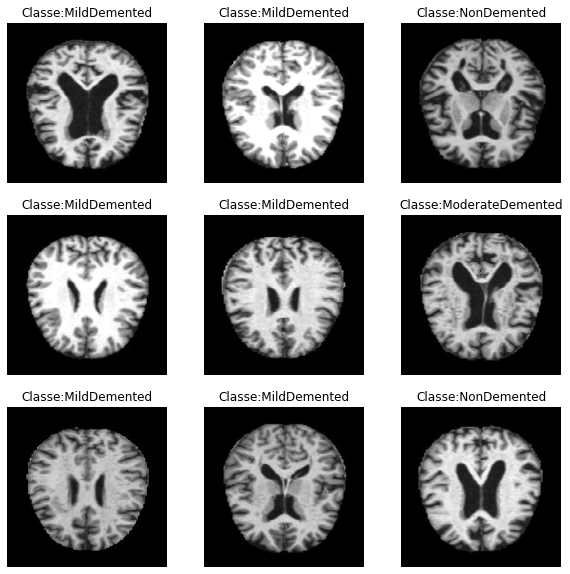

In [ ]:
def show_images(generator,y_pred=None):
    
    # obter labels de imagem
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # obter um lote de imagens
    x,y = generator.next()
    
    # gera grade de 9 imagens
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Classe:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    

show_images(train_data_gen)

In [ ]:
# Recuperando os dados do iterador ImageDataGenerator
train_data, train_labels = train_data_gen.next()
# Conhecendo as dimensões do nosso conjunto de dados
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
oversample = SMOTE()

train_data = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

In [ ]:
train_data.shape

(6400, 92928)

In [ ]:
train_data, train_labels = oversample.fit_resample(train_data, train_labels)

In [ ]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

DIVISÃO TREINO E TESTE

In [ ]:
#Dividindo os dados em conjuntos de treinamento, teste e validação

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

CONSTRUINDO MODELO

In [ ]:
model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 87, 87, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 87, 87, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

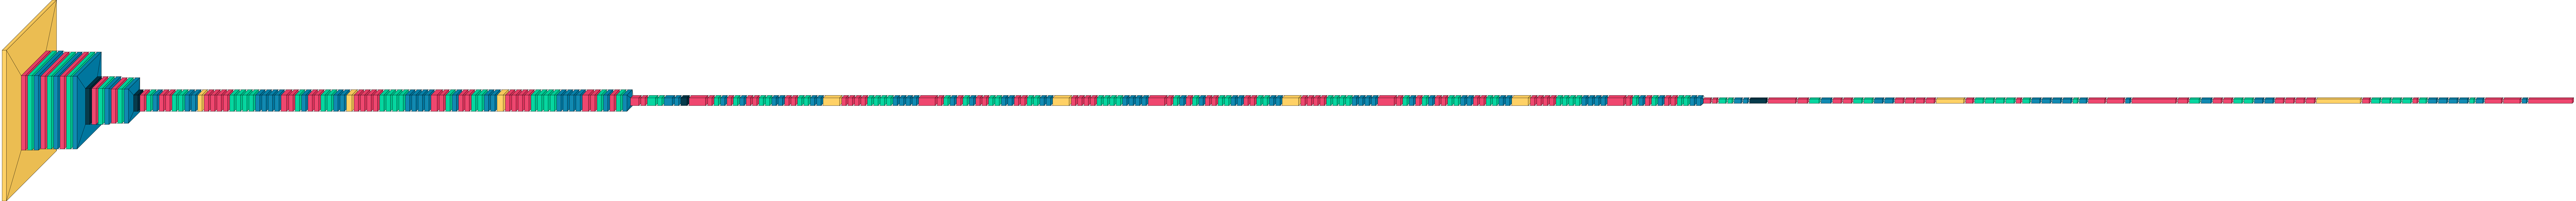

In [ ]:
visualkeras.layered_view(model)

In [ ]:
last_output= model.layers[-1].output

last_output= Flatten()(last_output)

model1= Model(model.input, last_output)

In [ ]:
x= Dense(units=128, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=32, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=1, activation="sigmoid")(x)

inception_model= Model(model1.input, x)

inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 87, 87, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 87, 87, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

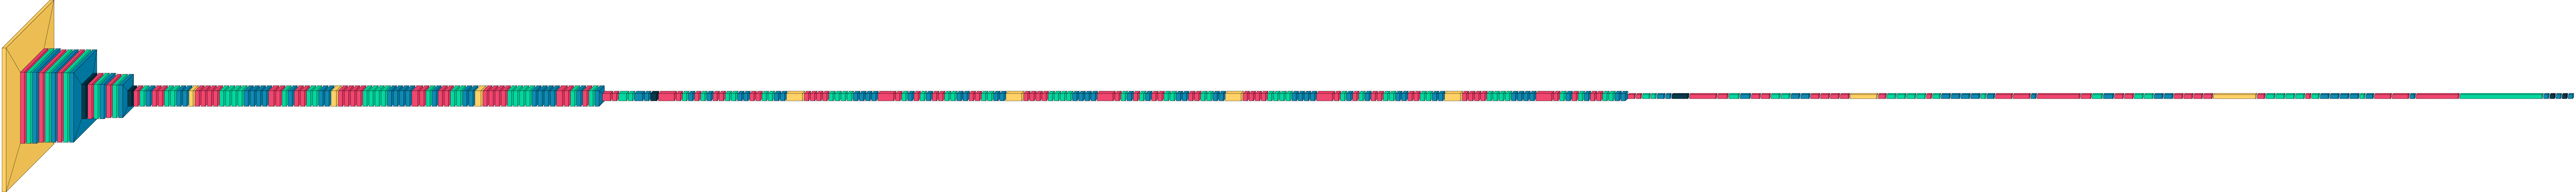

In [ ]:
visualkeras.layered_view(inception_model)

METRICAS

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='acuracia'),
            tf.keras.metrics.Precision(name='precisão'),
            tf.keras.metrics.Recall(name='recall'),  
            tf.keras.metrics.AUC(name='auc'),
            #tfa.metrics.F1Score(num_classes=4)
            f1_score
           ]

In [ ]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # Quando rodar por 50 folds

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
#Fit dos dados de treinamento ao modelo e validá-lo usando os dados de validação
EPOCHS = 100

history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:



#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [ ]:
#Previsão dos dados de teste

pred_labels = inception_model.predict(test_data)

In [ ]:
#Como os rótulos são arrays softmax, precisamos arredondar para tê-los na forma de 0s e 1s,
#semelhante aos test_labels
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
#Plotar a matriz de confusão para entender a classificação em detalhes

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Diagnóstico da Doença de Alzheimer')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show(ax)

In [ ]:
print("Pontuação de precisão equilibrada: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Coeficiente de Correlação de Matthews: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))